In [25]:
import os
import json
import copy
import torch
import warnings
warnings.filterwarnings(action = 'ignore')
import torchvision

import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn 
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

from PIL import Image
from torchvision import transforms
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

from src.efficientv2 import EfficientNetV2

In [13]:
BATCH_SIZE = 16
NUM_CLASSES = 5

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
data_path = 'D:/workspace/data/cassava'

f = open(os.path.join(data_path, 'label_num_to_disease_map.json'))

labels = json.load(f)
labels

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [15]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df['disease'] = df['label'].apply(lambda x: labels[str(x)])
df.head()

,image_id,label,disease
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


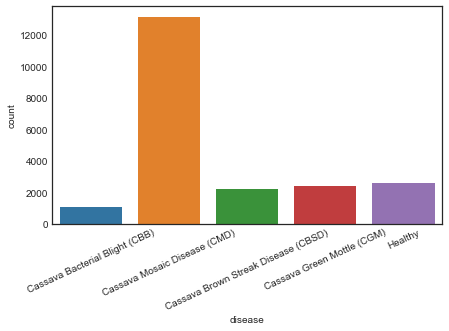

In [16]:
plt.figure(figsize = (7, 4))
plt.xticks(rotation = 25)
sns.countplot(df['disease']);

In [17]:
## Dataset

class CustomDataset(Dataset):
    def __init__(self, data_path, metadata, transform = None):
        super(CustomDataset, self).__init__()
        
        self.df = metadata
        self.data_path = data_path
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_name = self.df['image_id'].iloc[idx]
        class_label = torch.tensor(int(self.df['label'].iloc[idx]))
        
        img = Image.open(os.path.join(self.data_path, img_name))
        
        if self.transform is not None:
            img = self.transform(img)
            
        return (img, class_label)

In [18]:
def calculate_loss_and_accuracy(model, dataloader, size_of_dataset, criterion):
    
    running_loss = 0
    running_accuracy = 0
    
    # test
    for (inputs, labels) in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        
        running_loss += loss.item() * inputs.size(0)
        running_accuracy += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / size_of_dataset
    epoch_accuracy = running_accuracy / size_of_dataset
    
    return epoch_loss, epoch_accuracy

In [19]:
def train(model, criterion, optimizer, scheduler, num_of_epochs):
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_of_epochs):
        
        print(f'\nEpoch: {epoch+1} / {num_of_epochs}')
        print('-'*30)
        
        model.train()
        running_loss = 0
        running_accuracy = 0
        
        for (inputs, labels) in train_loader:
            
            nputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            _, preds = torch.max(inputs, 1)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_accuracy += torch.sum(preds == labels.data)
            
        scheduler.step()
        epoch_loss = running_loss / len(train_dataset)
        epoch_accuracy = running_accuracy / len(train_dataset)
        
        print(f'Training Loss: {epoch_loss:.4f} Training Acc: {epoch_accuracy:.4f}')
        
        model.eval()
        
        val_loss, val_accuracy = calculate_loss_and_accuracy(model, val_loader, len(val_dataset), criterion)
        
        if val_accuracy > best_acc:
            print("Found better model...")
            print('Updating the model weights....\n')
            print(f'Val Loss: {val_loss:.4f} Val Acc.: {val_accuracy:.4f}\n')

            best_acc = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            
    model.load_state_dict(best_model_wts) # update model
    
    return model

In [20]:
## Data Preparation

train_df = pd.DataFrame(columns = ['image_id', 'label'])
val_df = pd.DataFrame(columns = ['image_id', 'label'])

for label in df['label'].unique():
    temp_df = df[df['label'] == label].reset_index(drop = True)
    num_of_train_data = len(temp_df) * 80 // 100
    train_df = train_df.append(temp_df.iloc[0:num_of_train_data].reset_index(drop = True), ignore_index = True)
    val_df = val_df.append(temp_df.iloc[num_of_train_data:].reset_index(drop = True), ignore_index = True)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'Cassava Bacterial Blight (CBB)'),
  Text(1, 0, 'Cassava Mosaic Disease (CMD)'),
  Text(2, 0, 'Cassava Brown Streak Disease (CBSD)'),
  Text(3, 0, 'Cassava Green Mottle (CGM)'),
  Text(4, 0, 'Healthy')])

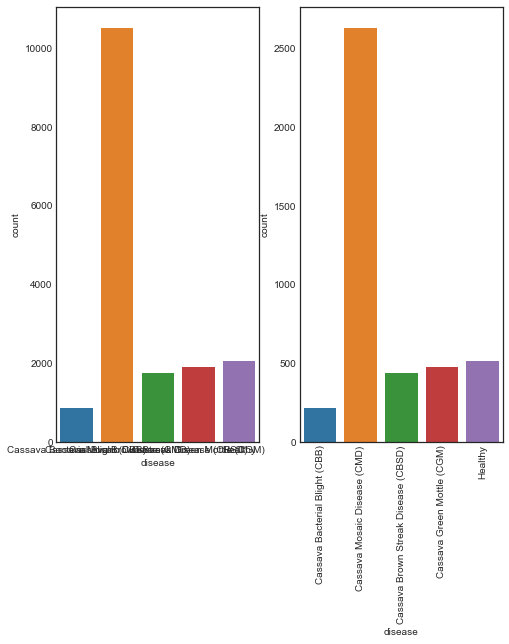

In [21]:
train_df['disease'] = train_df['label'].apply(lambda x: labels[str(x)])
val_df['disease'] = val_df['label'].apply(lambda x: labels[str(x)])

fig, ax = plt.subplots(1, 2, figsize = (8, 8))

sns.countplot(train_df['disease'], ax = ax[0])
sns.countplot(val_df['disease'], ax = ax[1])

plt.xticks(rotation = 90)

In [22]:
data_transforms = {
    "train" : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val" : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

train_dataset = CustomDataset(os.path.join(data_path, 'train_images'), train_df, transform = data_transforms['train'])
val_dataset = CustomDataset(os.path.join(data_path, 'train_images'), val_df, transform = data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = False)

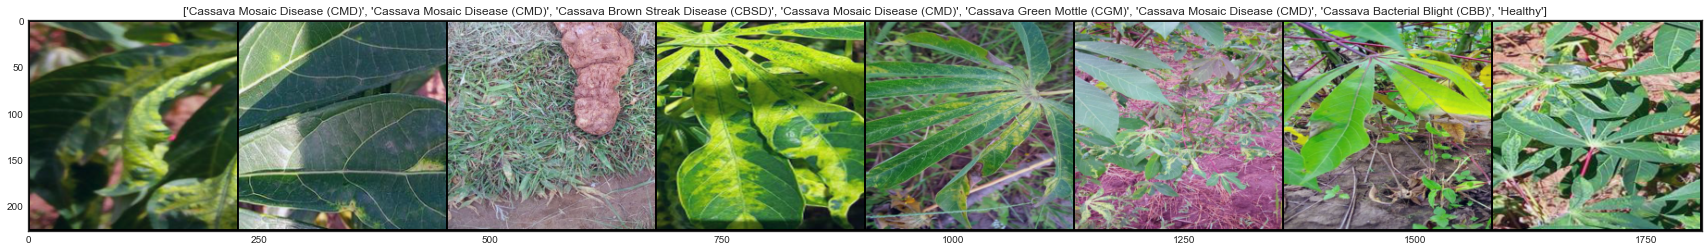

In [23]:
__ = DataLoader(train_dataset, batch_size = 8, shuffle = True)

for data in __:
    plt.figure(figsize = (30, 30))
    
    # batch_size 만큼 출력!
    img, label = data
    mg = torchvision.utils.make_grid(img, normalize = True, padding = 2)
    plt.imshow(mg.permute(1, 2, 0))
    plt.title([labels[str(np.array(label)[_])] for _ in range(len(label))])
    
    plt.show()
    
    break

In [24]:
version = 's'
model = EfficientNetV2(version = version, dropout_rate = .2, num_classes = NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = .9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = .1)

NUM_EPOCHS = 10

best_model = train(model = model,
                   criterion = criterion,
                   optimizer = optimizer,
                   scheduler = exp_lr_scheduler,
                   num_of_epochs = NUM_EPOCHS)


Epoch: 1 / 10
------------------------------


KeyboardInterrupt: 